# Cycling data from Auckland New Zeeland


You receive hourly data from the city of Auckland. They wanted to promote cycling in the city and decided to monitor cyclists to see how many cyclists travel through the city.

Your assignment is to make a forecasting model for the year 2018 (daily counts). Quantify the performance and see if you can improve your model by adding holidays and or weather.

I have aggregated the data for you in nice files so that you do not have to to the messy work.


daily counts: cycling_counts_by_day.csv

auckland weather: Auckland_weather_combined.csv

for holidays you can use the holidays python package

In [1]:
import pandas as pd
import numpy as np
import os

from prophet import Prophet
import holidays

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
cycling = pd.read_csv('cycling_counts_by_day.csv')
cycling

,datetime,Tamaki Drive EB
0,2010-07-01,570.0
1,2010-07-02,473.0
2,2010-07-03,766.0
3,2010-07-04,240.0
4,2010-07-05,172.0
...,...,...
2887,2018-05-27,235.0
2888,2018-05-28,709.0
2889,2018-05-29,859.0
2890,2018-05-30,787.0


In [3]:
cycling = cycling.rename(columns = {'datetime': 'ds', 'Tamaki Drive EB': 'y'})

In [4]:
cycling_train = cycling[cycling['ds']<'2018']
cycling_test = cycling[cycling['ds'] >= '2018']

print(cycling_train.head())
print(cycling_test.head())

           ds      y
0  2010-07-01  570.0
1  2010-07-02  473.0
2  2010-07-03  766.0
3  2010-07-04  240.0
4  2010-07-05  172.0
              ds       y
2741  2018-01-01   522.0
2742  2018-01-02  1179.0
2743  2018-01-03  1000.0
2744  2018-01-04   231.0
2745  2018-01-05    95.0


In [5]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(cycling_train)

23:05:58 - cmdstanpy - INFO - Chain [1] start processing
23:05:58 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
forecast_days = 152
future = m.make_future_dataframe(periods=forecast_days )
future

,ds
0,2010-07-01
1,2010-07-02
2,2010-07-03
3,2010-07-04
4,2010-07-05
...,...
2888,2018-05-28
2889,2018-05-29
2890,2018-05-30
2891,2018-05-31


In [7]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2888,2018-05-28,708.090278,464.077346,956.626985
2889,2018-05-29,811.666433,583.661492,1054.071815
2890,2018-05-30,735.436112,495.127731,977.936516
2891,2018-05-31,721.871626,480.023852,949.461866
2892,2018-06-01,668.158505,450.870685,896.338877


C:\Users\Ananya Gyanmote\AppData\Local\Temp\ipykernel_24884\4090623165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['ds'] = pd.to_datetime(predictions['ds'])
C:\Users\Ananya Gyanmote\AppData\Local\Temp\ipykernel_24884\4090623165.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truth['ds'] = pd.to_datetime(truth['ds'])


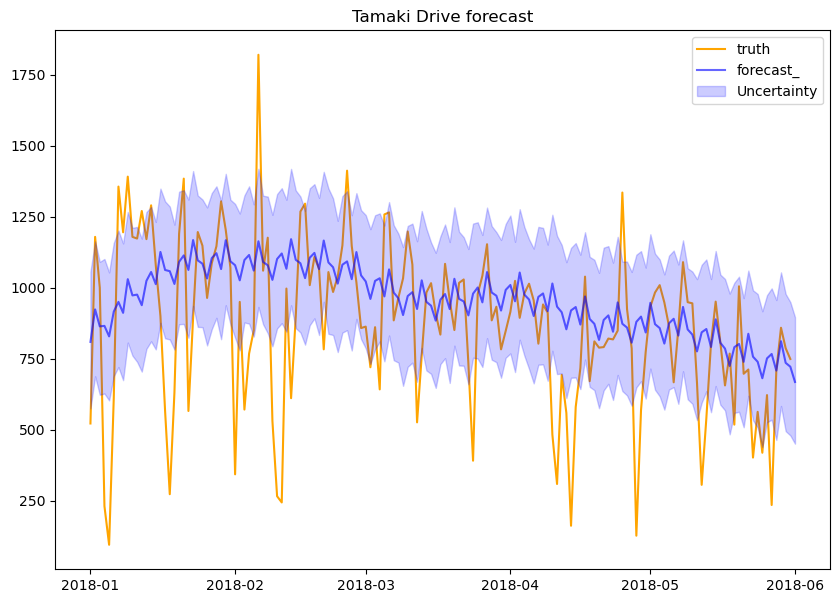

In [8]:
def show_graph_large(forecast_, test, label):
    predictions = forecast_[forecast_['ds']>= '2018' ]
    predictions['ds'] = pd.to_datetime(predictions['ds'])

#    truth = cycling_test
    truth = test
    truth['ds'] = pd.to_datetime(truth['ds'])

    plt.figure(figsize = (10,7))
    plt.plot(truth['ds'], truth['y'], label = 'truth', color = 'orange', zorder = 0)
    plt.plot(predictions['ds'], predictions['yhat'], label='forecast_', zorder = 1, color = 'blue', alpha = .6)
    #, zorder = 1, color = 'blue', alpha = .6)
    plt.fill_between(predictions['ds'], predictions['yhat_upper'], predictions['yhat_lower'], alpha=.2, label='Uncertainty', color = 'blue')

    #plt.xlim([pd.to_datetime('2018-02-02'), pd.to_datetime('2018-03-02')])

#    plt.title('Tamaki Drive forecast_')
    plt.title(label)
    plt.legend()
    plt.show()
    return truth

truth = show_graph_large(forecast_=forecast, test=cycling_test, label='Tamaki Drive forecast')


In [9]:
def find_rmse(forecast_, truth_):
    metric_df = forecast_.set_index('ds')[['yhat']].join(truth_.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    return np.sqrt(mean_squared_error(metric_df.y, metric_df.yhat))

print(find_rmse(forecast_=forecast, truth_=truth))    

286.27620463457635


# Adding weather

In [10]:
weather = pd.read_csv('Auckland_weather_combined.csv', sep = ";")
weather = weather.rename(columns = {'day':'ds'})
weather['ds'] = pd.to_datetime(weather['ds'])
weather

,ds,sun,wind,rain,temp
0,2012-01-01,0.161071,5.578571,0.000000,20.250000
1,2012-01-02,0.295238,10.820000,0.000000,18.400000
2,2012-01-03,0.588095,5.171429,0.028571,19.814286
3,2012-01-04,0.325238,3.778571,0.402381,19.857143
4,2012-01-05,0.595238,3.257143,0.079286,20.478571
...,...,...,...,...,...
2339,2018-05-28,0.604762,3.200000,0.000000,9.200000
2340,2018-05-29,1.459762,2.571429,0.000000,8.385714
2341,2018-05-30,1.359762,2.587500,0.000000,8.335714
2342,2018-05-31,1.483571,2.057143,0.000000,8.957143


In [11]:
cycling_train_weather = cycling_train.copy()
cycling_test_weather = cycling_test.copy()

cycling_train_weather['ds'] = pd.to_datetime(cycling_train_weather['ds'])
cycling_test_weather['ds'] = pd.to_datetime(cycling_test_weather['ds'])

cycling_train_weather = cycling_train_weather.merge(weather, on = 'ds')
cycling_test_weather = cycling_test_weather.merge(weather, on = 'ds')

print(cycling_train_weather.head())
print(cycling_test_weather.head())

          ds      y       sun       wind      rain       temp
0 2012-01-01  792.0  0.161071   5.578571  0.000000  20.250000
1 2012-01-02  500.0  0.295238  10.820000  0.000000  18.400000
2 2012-01-03  711.0  0.588095   5.171429  0.028571  19.814286
3 2012-01-04  852.0  0.325238   3.778571  0.402381  19.857143
4 2012-01-05  820.0  0.595238   3.257143  0.079286  20.478571
          ds       y       sun       wind      rain       temp
0 2018-01-01   522.0  0.054762   3.721429  0.476190  21.642857
1 2018-01-02  1179.0  1.886429   3.635714  0.000000  23.485714
2 2018-01-03  1000.0  1.601429   3.866667  0.035714  23.171429
3 2018-01-04   231.0  0.000000   6.092857  4.983095  21.520000
4 2018-01-05    95.0  0.000000  10.100000  2.285119  19.575000


In [12]:
m = Prophet(seasonality_mode='multiplicative')
m.add_regressor('sun')
m.add_regressor('rain')
m.fit(cycling_train_weather)

23:05:59 - cmdstanpy - INFO - Chain [1] start processing
23:05:59 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
forecast_days = 152
future = m.make_future_dataframe(periods=forecast_days )
future = future.merge(weather, on = 'ds')
future

,ds,sun,wind,rain,temp
0,2012-01-01,0.161071,5.578571,0.000000,20.250000
1,2012-01-02,0.295238,10.820000,0.000000,18.400000
2,2012-01-03,0.588095,5.171429,0.028571,19.814286
3,2012-01-04,0.325238,3.778571,0.402381,19.857143
4,2012-01-05,0.595238,3.257143,0.079286,20.478571
...,...,...,...,...,...
2339,2018-05-28,0.604762,3.200000,0.000000,9.200000
2340,2018-05-29,1.459762,2.571429,0.000000,8.385714
2341,2018-05-30,1.359762,2.587500,0.000000,8.335714
2342,2018-05-31,1.483571,2.057143,0.000000,8.957143


In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2339,2018-05-28,718.241397,537.157167,903.326218
2340,2018-05-29,972.729754,779.720867,1157.844409
2341,2018-05-30,903.039165,724.186034,1085.326835
2342,2018-05-31,900.171418,726.829307,1085.000750
2343,2018-06-01,823.583981,632.676278,1011.887693


C:\Users\Ananya Gyanmote\AppData\Local\Temp\ipykernel_24884\4090623165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['ds'] = pd.to_datetime(predictions['ds'])


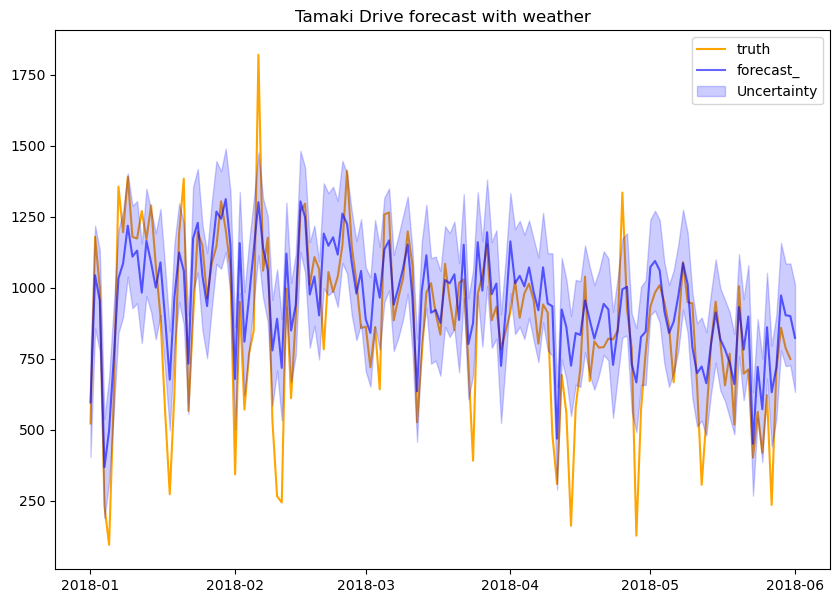

In [15]:
truth = show_graph_large(forecast_=forecast, test=cycling_test_weather, label='Tamaki Drive forecast with weather')

In [16]:

find_rmse(forecast_=forecast, truth_=truth)
#195.700

195.7008423324702

## Week Weather

In [17]:
lower_lmt = pd.to_datetime('2018-02-04')
upper_lmt = pd.to_datetime('2018-02-12')
grt = forecast[forecast['ds'] < upper_lmt] 
range_weather_f = grt[grt['ds'] > lower_lmt]
grt = truth[truth['ds'] < upper_lmt]
range_weather_t = grt[grt['ds'] > lower_lmt]

In [18]:
metric_df = range_weather_f.set_index('ds')[['yhat']].join(range_weather_t.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
np.sqrt(mean_squared_error(metric_df.y, metric_df.yhat))

find_rmse(forecast_=range_weather_f, truth_=range_weather_t)
#386.33

386.3338166841278

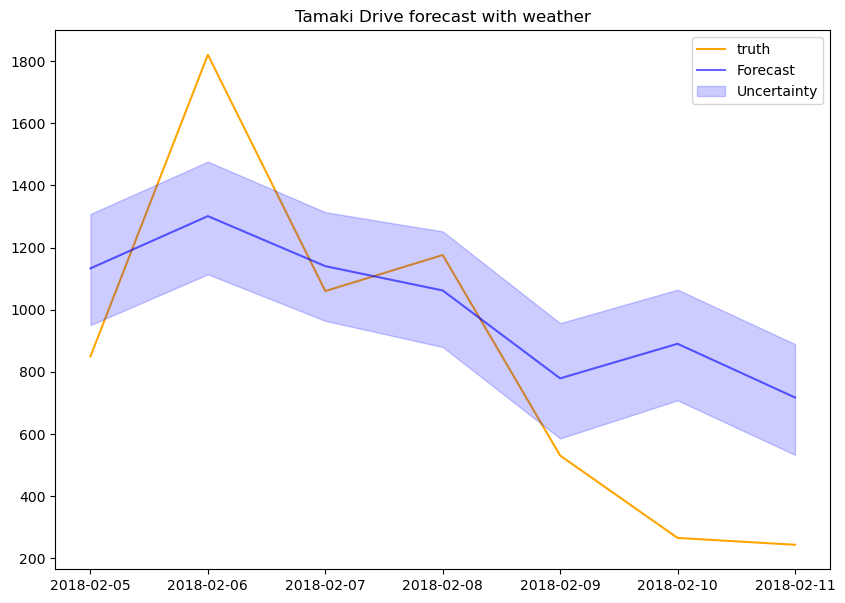

In [19]:
plt.figure(figsize = (10,7))
plt.plot(range_weather_t['ds'], range_weather_t['y'], label = 'truth', color = 'orange', zorder = 0)
plt.plot(range_weather_f['ds'], range_weather_f['yhat'], label='Forecast', zorder = 1, color = 'blue', alpha = .6)
plt.fill_between(range_weather_f['ds'], range_weather_f['yhat_upper'], range_weather_f['yhat_lower'], alpha=.2, label='Uncertainty', color = 'blue')

#plt.xlim([pd.to_datetime('2018-02-02'), pd.to_datetime('2018-03-02')])

plt.title('Tamaki Drive forecast with weather')
plt.legend()
plt.show()



# Adding holidays

In [20]:
holidays_nz = holidays.country_holidays("NZ")

In [21]:
'02/06/2018' in holidays.country_holidays("NZ") # mm / dd / yyyy

True

In [22]:
holidays_cycling_df = pd.read_csv('cycling_counts_by_day.csv')
holidays_cycling_df.rename(columns = {'datetime': 'ds', 'Tamaki Drive EB': 'y'}, inplace = True)
holidays_cycling_df['ds'] = pd.to_datetime(holidays_cycling_df['ds'])

In [23]:
holidays_cycling_df["holidays_str"] = pd.Series(holidays_cycling_df.ds).apply(lambda x: holidays_nz.get(x)).values

In [24]:
holidays_cycling_df["holidays_str"].unique()

array([None, 'Labour Day', 'Christmas Day', 'Boxing Day',
       'Christmas Day (Observed)', 'Boxing Day (Observed)',
       "New Year's Day", "Day after New Year's Day",
       "New Year's Day (Observed)", "Day after New Year's Day (Observed)",
       'Waitangi Day', 'Good Friday', 'Anzac Day; Easter Monday',
       "Queen's Birthday", 'Easter Monday', 'Anzac Day',
       'Anzac Day (Observed)', 'Waitangi Day (Observed)'], dtype=object)

In [25]:
holidays_cycling_df[holidays_cycling_df["holidays_str"] == 'Waitangi Day (Observed)']

,ds,y,holidays_str
2048,2016-02-08,1235.0,Waitangi Day (Observed)


In [26]:
holidays_df = holidays_cycling_df.copy()
holidays_df.drop("y", axis = 1, inplace=True)
holidays_df.rename(columns = {'holidays_str': 'holiday'}, inplace = True)
holidays_df = holidays_df.dropna()
print(holidays_df)

             ds                   holiday
116  2010-10-25                Labour Day
177  2010-12-25             Christmas Day
178  2010-12-26                Boxing Day
179  2010-12-27  Christmas Day (Observed)
180  2010-12-28     Boxing Day (Observed)
...         ...                       ...
2742 2018-01-02  Day after New Year's Day
2777 2018-02-06              Waitangi Day
2829 2018-03-30               Good Friday
2832 2018-04-02             Easter Monday
2855 2018-04-25                 Anzac Day

[90 rows x 2 columns]


In [27]:
holidays_cycling_df.drop("holidays_str", axis= 1, inplace=True)
print(holidays_cycling_df)

             ds      y
0    2010-07-01  570.0
1    2010-07-02  473.0
2    2010-07-03  766.0
3    2010-07-04  240.0
4    2010-07-05  172.0
...         ...    ...
2887 2018-05-27  235.0
2888 2018-05-28  709.0
2889 2018-05-29  859.0
2890 2018-05-30  787.0
2891 2018-05-31  749.0

[2892 rows x 2 columns]


In [28]:
holidays_train = cycling_train.copy()
holidays_test = cycling_test.copy()

holidays_train['ds'] = pd.to_datetime(holidays_train['ds'])
holidays_test['ds'] = pd.to_datetime(holidays_test['ds'])

print(holidays_train.head())
print(holidays_test.head())

#holidays_train = holidays_train.merge(holidays_cycling_df, on = 'ds')
#holidays_test = holidays_test.merge(holidays_cycling_df, on = 'ds')


print(holidays_cycling_df.head())

          ds      y
0 2010-07-01  570.0
1 2010-07-02  473.0
2 2010-07-03  766.0
3 2010-07-04  240.0
4 2010-07-05  172.0
             ds       y
2741 2018-01-01   522.0
2742 2018-01-02  1179.0
2743 2018-01-03  1000.0
2744 2018-01-04   231.0
2745 2018-01-05    95.0
          ds      y
0 2010-07-01  570.0
1 2010-07-02  473.0
2 2010-07-03  766.0
3 2010-07-04  240.0
4 2010-07-05  172.0


In [29]:
m = Prophet(holidays = holidays_df)
#m.add_country_holidays(country_name='NZ')
m.fit(holidays_train)

23:06:01 - cmdstanpy - INFO - Chain [1] start processing
23:06:01 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
forecast_days = 152
future = m.make_future_dataframe(periods=forecast_days )
future = future.merge(holidays_cycling_df, on = 'ds')
future

,ds,y
0,2010-07-01,570.0
1,2010-07-02,473.0
2,2010-07-03,766.0
3,2010-07-04,240.0
4,2010-07-05,172.0
...,...,...
2887,2018-05-27,235.0
2888,2018-05-28,709.0
2889,2018-05-29,859.0
2890,2018-05-30,787.0


In [31]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2887,2018-05-27,783.999858,546.454226,1012.078014
2888,2018-05-28,729.835767,506.704355,958.191771
2889,2018-05-29,813.957789,581.131475,1029.184863
2890,2018-05-30,754.136823,534.339166,980.961428
2891,2018-05-31,741.778481,502.750692,980.633214


C:\Users\Ananya Gyanmote\AppData\Local\Temp\ipykernel_24884\4090623165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['ds'] = pd.to_datetime(predictions['ds'])


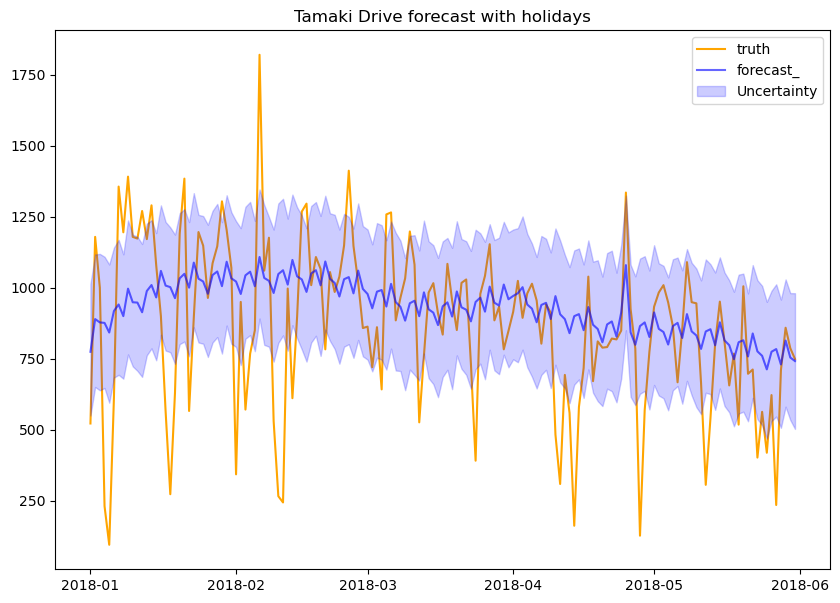

In [32]:

truth = show_graph_large(forecast_=forecast, test=holidays_test, label='Tamaki Drive forecast with holidays')

In [33]:

find_rmse(forecast_=forecast, truth_=truth)

277.65665730122237

## Week Holiday

In [34]:
lower_lmt = pd.to_datetime('2018-02-04')
upper_lmt = pd.to_datetime('2018-02-12')
grt = forecast[forecast['ds'] < upper_lmt] 
range_holiday_p = grt[grt['ds'] > lower_lmt]
grt = truth[truth['ds'] < upper_lmt]
range_holiday_t = grt[grt['ds'] > lower_lmt]

In [35]:

find_rmse(forecast_=range_holiday_p, truth_=range_holiday_t)
#539.

539.483563764878

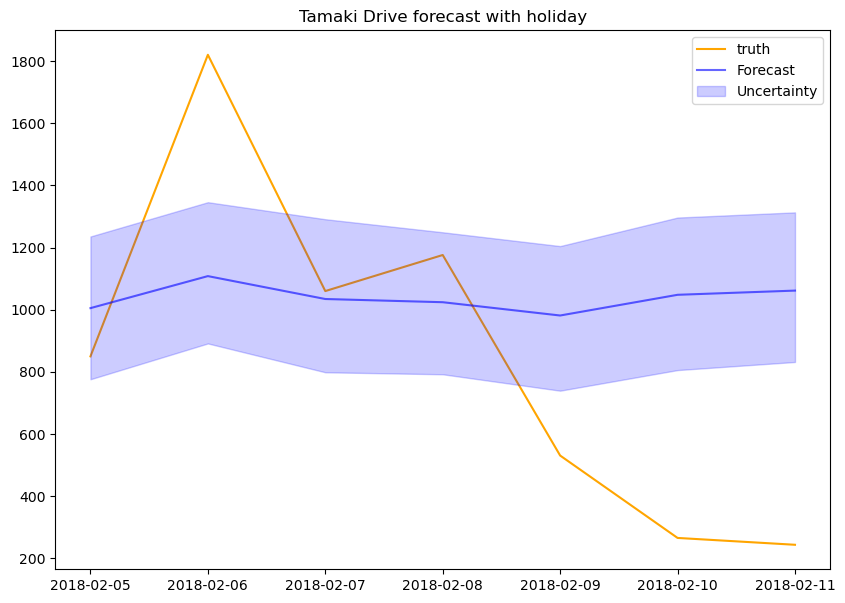

In [36]:
plt.figure(figsize = (10,7))
plt.plot(range_holiday_t['ds'], range_holiday_t['y'], label = 'truth', color = 'orange', zorder = 0)
plt.plot(range_holiday_p['ds'], range_holiday_p['yhat'], label='Forecast', zorder = 1, color = 'blue', alpha = .6)
plt.fill_between(range_holiday_p['ds'], range_holiday_p['yhat_upper'], range_holiday_p['yhat_lower'], alpha=.2, label='Uncertainty', color = 'blue')

#plt.xlim([pd.to_datetime('2018-02-02'), pd.to_datetime('2018-03-02')])

plt.title('Tamaki Drive forecast with holiday')
plt.legend()
plt.show()



Since the rmse of weather is better than holidays, the model with weather is better.

## Testing different method

In [37]:
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='NZ')
m.fit(holidays_train)

23:06:03 - cmdstanpy - INFO - Chain [1] start processing
23:06:04 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
forecast_days = 152
future = m.make_future_dataframe(periods=forecast_days )
future = future.merge(holidays_cycling_df, on = 'ds')
future

,ds,y
0,2010-07-01,570.0
1,2010-07-02,473.0
2,2010-07-03,766.0
3,2010-07-04,240.0
4,2010-07-05,172.0
...,...,...
2887,2018-05-27,235.0
2888,2018-05-28,709.0
2889,2018-05-29,859.0
2890,2018-05-30,787.0


In [39]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2887,2018-05-27,773.241199,558.599033,997.707257
2888,2018-05-28,711.862693,465.708733,961.688273
2889,2018-05-29,817.787364,579.061771,1047.531383
2890,2018-05-30,738.456021,515.320707,965.576391
2891,2018-05-31,724.300374,506.108547,970.076562


C:\Users\Ananya Gyanmote\AppData\Local\Temp\ipykernel_24884\4090623165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['ds'] = pd.to_datetime(predictions['ds'])


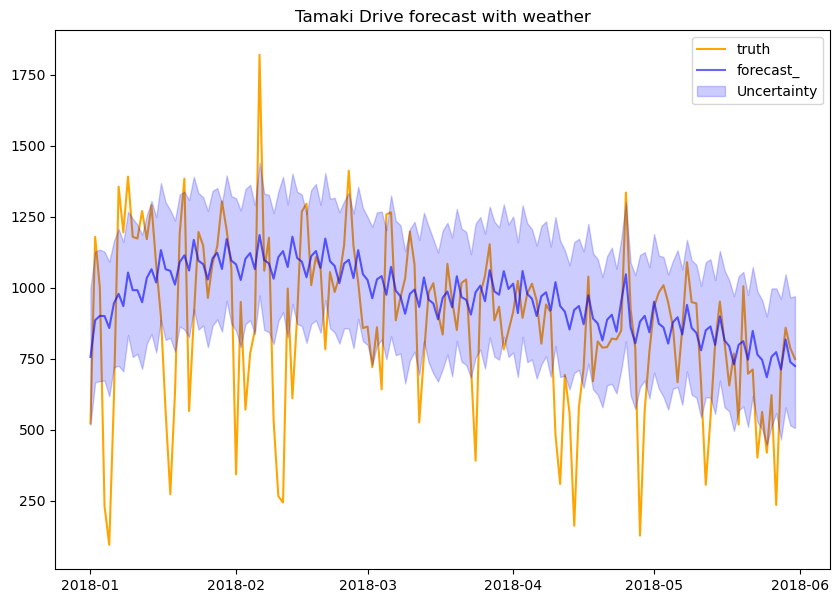

In [40]:


truth = show_graph_large(forecast_=forecast, test=holidays_test, label='Tamaki Drive forecast with weather')

In [41]:


find_rmse(forecast_=forecast, truth_=truth)
#286.92

286.92118476384826

## Week Holiday

In [42]:
lower_lmt = pd.to_datetime('2018-02-04')
upper_lmt = pd.to_datetime('2018-02-12')
grt = forecast[forecast['ds'] < upper_lmt] 
range_holiday_p = grt[grt['ds'] > lower_lmt]
grt = truth[truth['ds'] < upper_lmt]
range_holiday_t = grt[grt['ds'] > lower_lmt]

In [43]:

find_rmse(forecast_=range_holiday_p, truth_=range_holiday_t)
#560.71

560.7157679649735

Now we know that the best way to do it is with the holidays Framework as the rmse of it is lower than 560.

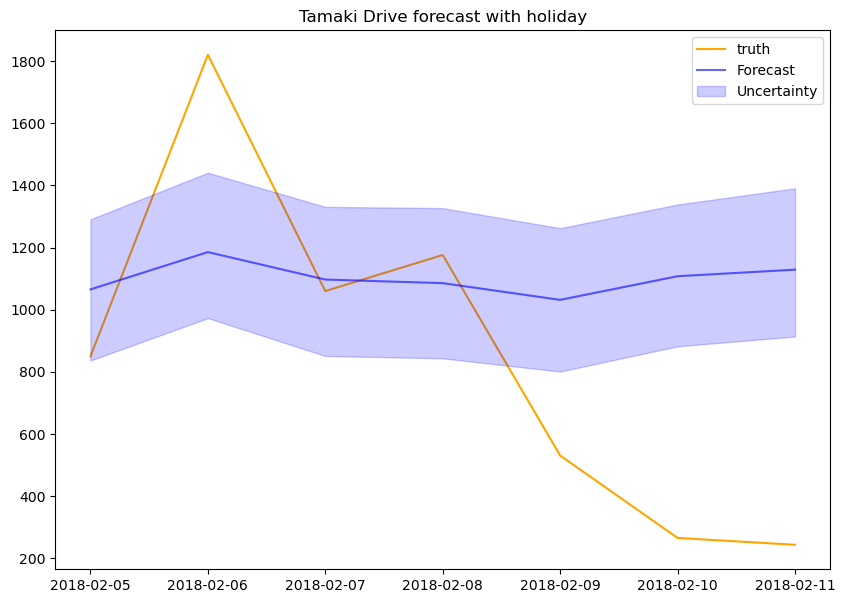

In [44]:
plt.figure(figsize = (10,7))
plt.plot(range_holiday_t['ds'], range_holiday_t['y'], label = 'truth', color = 'orange', zorder = 0)
plt.plot(range_holiday_p['ds'], range_holiday_p['yhat'], label='Forecast', zorder = 1, color = 'blue', alpha = .6)
plt.fill_between(range_holiday_p['ds'], range_holiday_p['yhat_upper'], range_holiday_p['yhat_lower'], alpha=.2, label='Uncertainty', color = 'blue')

#plt.xlim([pd.to_datetime('2018-02-02'), pd.to_datetime('2018-03-02')])

plt.title('Tamaki Drive forecast with holiday')
plt.legend()
plt.show()



# Adding Holiday and Weather

In [45]:
m = Prophet(seasonality_mode='multiplicative', holidays = holidays_df)
m.add_regressor('sun')
m.add_regressor('rain')
m.fit(cycling_train_weather)

23:06:06 - cmdstanpy - INFO - Chain [1] start processing
23:06:06 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
forecast_days = 152
future = m.make_future_dataframe(periods=forecast_days )
future = future.merge(weather, on = 'ds')
future

,ds,sun,wind,rain,temp
0,2012-01-01,0.161071,5.578571,0.000000,20.250000
1,2012-01-02,0.295238,10.820000,0.000000,18.400000
2,2012-01-03,0.588095,5.171429,0.028571,19.814286
3,2012-01-04,0.325238,3.778571,0.402381,19.857143
4,2012-01-05,0.595238,3.257143,0.079286,20.478571
...,...,...,...,...,...
2339,2018-05-28,0.604762,3.200000,0.000000,9.200000
2340,2018-05-29,1.459762,2.571429,0.000000,8.385714
2341,2018-05-30,1.359762,2.587500,0.000000,8.335714
2342,2018-05-31,1.483571,2.057143,0.000000,8.957143


In [47]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2339,2018-05-28,711.094222,524.643893,876.296500
2340,2018-05-29,969.866030,792.617653,1156.960750
2341,2018-05-30,900.446259,699.222807,1069.102510
2342,2018-05-31,897.123537,721.436207,1068.193135
2343,2018-06-01,817.299442,642.818179,991.798792


C:\Users\Ananya Gyanmote\AppData\Local\Temp\ipykernel_24884\4090623165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['ds'] = pd.to_datetime(predictions['ds'])


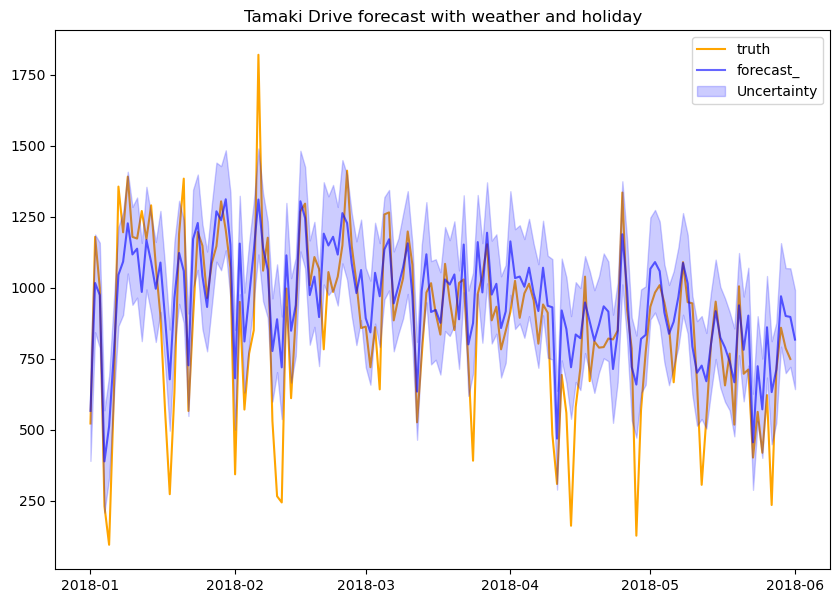

In [48]:

truth = show_graph_large(forecast_=forecast, test=cycling_test_weather, label='Tamaki Drive forecast with weather and holiday')

In [49]:

find_rmse(forecast_=forecast, truth_=truth)

#193.48

193.48840623764553

## Week Weather and Holidays

In [50]:
lower_lmt = pd.to_datetime('2018-02-04')
upper_lmt = pd.to_datetime('2018-02-12')
grt = forecast[forecast['ds'] < upper_lmt] 
range_weather_holiday_p = grt[grt['ds'] > lower_lmt]
grt = truth[truth['ds'] < upper_lmt]
range_weather_holiday_t = grt[grt['ds'] > lower_lmt]

In [52]:

find_rmse(forecast_=range_weather_holiday_p, truth_=range_weather_holiday_t)
#383.87

383.87497562278753

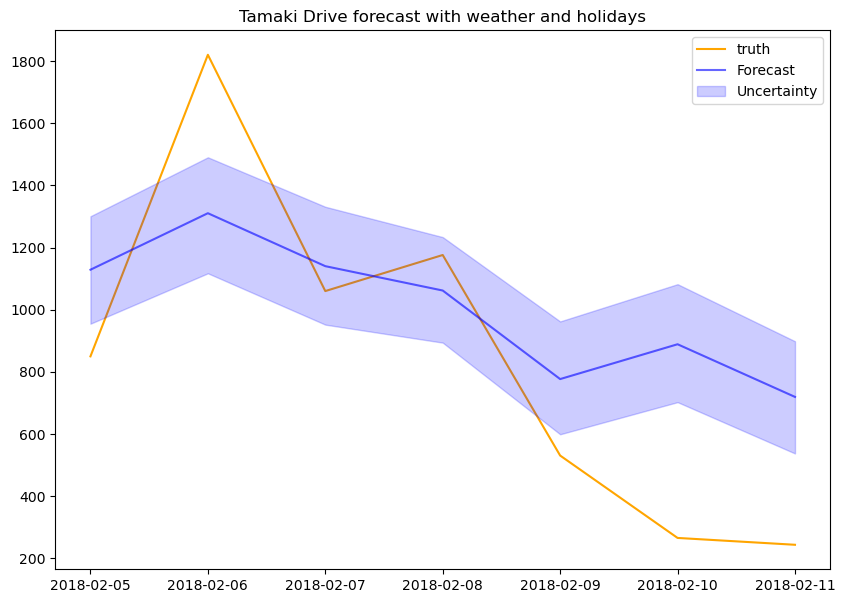

In [53]:
plt.figure(figsize = (10,7))
plt.plot(range_weather_holiday_t['ds'], range_weather_holiday_t['y'], label = 'truth', color = 'orange', zorder = 0)
plt.plot(range_weather_holiday_p['ds'], range_weather_holiday_p['yhat'], label='Forecast', zorder = 1, color = 'blue', alpha = .6)
plt.fill_between(range_weather_holiday_p['ds'], range_weather_holiday_p['yhat_upper'], range_weather_holiday_p['yhat_lower'], alpha=.2, label='Uncertainty', color = 'blue')

#plt.xlim([pd.to_datetime('2018-02-02'), pd.to_datetime('2018-03-02')])

plt.title('Tamaki Drive forecast with weather and holidays')
plt.legend()
plt.show()



# Questions

### A) Is there a decrease in RMSE when you add holidays?
There is a decrease in RMSE when we use only holidays, but when we use both holidays and weather, the RMSE is lower, which means that the model with both weather and holidays is a better model.

### B) Give your own interpretation of the fit (did it improve the prediction on waitangi day or not)
When we fitted the holidays, the predictions did not improve but when we fitted both holidays and weather, the predictions improved. As, we can observe below I can say that it is because the fact that it is a holiday or not doesn't matter as much because the most important thing bickers need is a good weather. Hence, the cycling counts are more dependent on the weather than holidays.

### C) if it does not work you should investigate why and try to get it to work, or explain why it will not work
The code works completely fine for me.

In [54]:
pd.set_option('display.max_columns', 7)
pd.set_option("display.max_rows", None)

In [55]:
wea_holidays = pd.merge(weather, holidays_df, on='ds', how='inner')

cycling['ds'] = pd.to_datetime(cycling['ds'])
wea_holidays = pd.merge(wea_holidays, cycling, on="ds", how="inner")

In [56]:
wea_holidays
# cycling counts by day

,ds,sun,wind,rain,temp,holiday,y
0,2012-01-01,0.161071,5.578571,0.000000,20.250000,New Year's Day,792.0
1,2012-01-02,0.295238,10.820000,0.000000,18.400000,Day after New Year's Day,500.0
2,2012-01-03,0.588095,5.171429,0.028571,19.814286,New Year's Day (Observed),711.0
3,2012-02-06,0.079286,3.258333,0.000000,19.321429,Waitangi Day,720.0
4,2012-04-06,1.819048,3.035714,0.000000,18.371429,Good Friday,1022.0
5,2012-04-09,1.754762,5.092857,0.000000,17.964286,Easter Monday,777.0
6,2012-04-25,1.446905,2.707143,0.000000,17.792857,Anzac Day,1039.0
7,2012-06-04,0.652262,2.166667,0.000000,13.128571,Queen's Birthday,711.0
8,2012-10-22,0.745357,7.980000,0.023810,16.485714,Labour Day,666.0
9,2012-12-25,0.111905,8.214286,0.421429,21.157143,Christmas Day,171.0


In [57]:
cycling

,ds,y
0,2010-07-01,570.0
1,2010-07-02,473.0
2,2010-07-03,766.0
3,2010-07-04,240.0
4,2010-07-05,172.0
5,2010-07-06,423.0
6,2010-07-07,401.0
7,2010-07-08,496.0
8,2010-07-09,915.0
9,2010-07-10,646.0
